In [1]:
import scanpy as sc
import numpy as np
import scvelo as scv
import anndata as ad
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from pathlib import Path
import re
from scipy.sparse import issparse
from scipy import sparse as sp

In [2]:
loom_hfd = sc.read("/gpfsdata/home/renyixiang/SRTP/DeepVelo/vgMG_HFD/velocyto/vgMG_HFD.loom")
loom_nd  = sc.read("/gpfsdata/home/renyixiang/SRTP/DeepVelo/vgMG_ND/velocyto/vgMG_ND.loom")

In [3]:
ND_anndata = sc.read_h5ad("/gpfsdata/home/renyixiang/SRTP/DeepVelo/ND_epi.h5ad")
HFD_anndata = sc.read_h5ad("/gpfsdata/home/renyixiang/SRTP/DeepVelo/HFD_epi.h5ad")

In [ ]:
print("ND h5ad (head):", list(ND_anndata.obs_names[:8]))
print("ND loom  (head):", list(loom_nd.obs_names[:8]))
print("HFD h5ad (head):", list(HFD_anndata.obs_names[:8]))
print("HFD loom  (head):", list(loom_hfd.obs_names[:8]))

ND h5ad (head): ['ND_AAACCCAGTGGTTTAC-1', 'ND_AAACCCATCAGACAAA-1', 'ND_AAACGAACATCTTAGG-1', 'ND_AAACGAAGTATCACGT-1', 'ND_AAACGAATCGGCCTTT-1', 'ND_AAACGCTCATTGTCGA-1', 'ND_AAAGAACGTCTACGTA-1', 'ND_AAAGGATAGAGGCCAT-1']
ND loom  (head): ['vgMG_ND:AAACGCTAGGTATAGTx', 'vgMG_ND:AAACGCTTCGCTTACCx', 'vgMG_ND:AACAAAGAGCCACAAGx', 'vgMG_ND:AAACGAATCGGCCTTTx', 'vgMG_ND:AAAGGGCTCTCCATATx', 'vgMG_ND:AAACGCTAGTAGAGTTx', 'vgMG_ND:AAAGGATCAGGTTTACx', 'vgMG_ND:AAACGAATCTCACTCGx']
HFD h5ad (head): ['HFD_AAACGAAAGGTTTACC-1', 'HFD_AAAGGGCAGCAGGCAT-1', 'HFD_AAAGGTATCGTTCTAT-1', 'HFD_AAAGTCCTCTACGGGC-1', 'HFD_AACAAAGGTGGTTCTA-1', 'HFD_AACAAGAAGCGTTAGG-1', 'HFD_AACAAGAGTCGAACGA-1', 'HFD_AACACACTCTAACGGT-1']
HFD loom  (head): ['vgMG_HFD:AAACGCTAGCGAGTACx', 'vgMG_HFD:AAAGGGCAGAGCACTGx', 'vgMG_HFD:AACAAAGCACTGCGTGx', 'vgMG_HFD:AAAGGGCCAGTATTCGx', 'vgMG_HFD:AAAGTGAGTGATTAGAx', 'vgMG_HFD:AAAGGATTCATGCCAAx', 'vgMG_HFD:AAATGGACAATTCGTGx', 'vgMG_HFD:AAATGGAGTCCGGTCAx']


In [ ]:
def normalize_barcodes(index, keep=16):
    s = pd.Index(index.astype(str))
    s = s.str.replace(r'^[^:]*:', '', regex=True)         
    s = s.str.replace(r'^(ND_|HFD_)', '', regex=True)       
    s = s.str.replace(r'(-1|x|X)$', '', regex=True)                   
    return s

for ad in (ND_anndata, HFD_anndata, loom_nd, loom_hfd):
    ad.var_names_make_unique()

ND_anndata.obs["barcode_raw"]  = ND_anndata.obs_names
HFD_anndata.obs["barcode_raw"] = HFD_anndata.obs_names
loom_nd.obs["barcode_raw"]     = loom_nd.obs_names
loom_hfd.obs["barcode_raw"]    = loom_hfd.obs_names

ND_anndata.obs_names  = normalize_barcodes(ND_anndata.obs_names)
HFD_anndata.obs_names = normalize_barcodes(HFD_anndata.obs_names)
loom_nd.obs_names     = normalize_barcodes(loom_nd.obs_names)
loom_hfd.obs_names    = normalize_barcodes(loom_hfd.obs_names)


def manual_merge_layers(adata, ldata):
    cells = adata.obs_names.intersection(ldata.obs_names)
    if len(cells) == 0:
        raise ValueError("两侧 obs_names 无交集，请检查规范化。")
    adata = adata[cells].copy()
    ldata = ldata[cells].copy()
    genes = adata.var_names.intersection(ldata.var_names)
    adata = adata[:, genes].copy()
    ldata = ldata[:, genes].copy()

    for layer in ("spliced", "unspliced", "ambiguous"):
        if layer in ldata.layers:
            X = ldata.layers[layer]
            adata.layers[layer] = X if sp.issparse(X) else sp.csr_matrix(X)
    return adata

ND_anndata  = manual_merge_layers(ND_anndata,  loom_nd)
HFD_anndata = manual_merge_layers(HFD_anndata, loom_hfd)


In [5]:
scv.pp.filter_and_normalize(ND_anndata, min_shared_counts=20, n_top_genes=2000)
scv.pp.filter_and_normalize(HFD_anndata, min_shared_counts=20, n_top_genes=2000)
scv.pp.moments(ND_anndata, n_pcs=30, n_neighbors=30)
scv.pp.moments(HFD_anndata, n_pcs=30, n_neighbors=30)

Filtered out 16223 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


Filtered out 18128 genes that are detected 20 counts (shared).
Normalized count data: spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_398156/869910452.py:3: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(ND_anndata, n_pcs=30, n_neighbors=30)
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:09) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities


/tmp/ipykernel_398156/869910452.py:4: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(HFD_anndata, n_pcs=30, n_neighbors=30)
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(


    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [6]:
scv.tl.velocity(ND_anndata, mode = "stochastic")

computing velocities


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [7]:
scv.tl.velocity(HFD_anndata, mode = "stochastic")

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/tools/optimization.py:184: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  gamma[i] = np.linalg.pinv(A.T.dot(A)).dot(A.T.dot(y[:, i]))


In [ ]:
import numpy as np
import pandas as pd

def deep_data_check_and_fix(adata, sample_name):
    print(f"Deep checking {sample_name}...")
    if 'velocity' in adata.layers:
        vel = adata.layers['velocity']
        print(f"  Velocity shape: {vel.shape}")
        print(f"  Velocity dtype: {vel.dtype}")
        print(f"  Velocity sparse: {hasattr(vel, 'toarray')}")
        
        # convert ti dense format
        if hasattr(vel, 'toarray'):
            vel = vel.toarray()
            adata.layers['velocity'] = vel
        
        cell_vel_lengths = []
        for i in range(vel.shape[0]):
            cell_vel = vel[i, :]
            cell_vel_lengths.append(len(cell_vel))
        
        unique_lengths = set(cell_vel_lengths)
        print(f"  Unique velocity vector lengths: {unique_lengths}")
        
        if len(unique_lengths) > 1:
            print("  WARNING: Inconsistent velocity vector lengths!")
            return False
    X = adata.X
    if hasattr(X, 'toarray'):
        X = X.toarray()
        adata.X = X
    
    print(f"  X shape: {X.shape}")
    print(f"  X dtype: {X.dtype}")
    
    print(f"  Gene names shape: {adata.var.shape}")
    print(f"  Cell names shape: {adata.obs.shape}")
    
    return True

nd_ok = deep_data_check_and_fix(ND_anndata, "ND")
hfd_ok = deep_data_check_and_fix(HFD_anndata, "HFD")

Deep checking ND...
  Velocity shape: (1391, 2000)
  Velocity dtype: float32
  Velocity sparse: False
  Unique velocity vector lengths: {2000}
  X shape: (1391, 2000)
  X dtype: float64
  Gene names shape: (2000, 13)
  Cell names shape: (1391, 15)
Deep checking HFD...
  Velocity shape: (765, 2000)
  Velocity dtype: float32
  Velocity sparse: False
  Unique velocity vector lengths: {2000}
  X shape: (765, 2000)
  X dtype: float64
  Gene names shape: (2000, 13)
  Cell names shape: (765, 15)


In [ ]:
def robust_velocity_graph(adata, sample_name, n_neighbors=15):
    print(f"\nRobust velocity graph computation for {sample_name}...")
    
    import scanpy as sc
    from scipy import sparse
    import numpy as np
    
    if 'neighbors' not in adata.uns:
        sc.pp.neighbors(adata, n_neighbors=n_neighbors, n_pcs=30)
    
    try:
        X = adata.layers['Ms']
        V = adata.layers['velocity']
        if sparse.issparse(X):
            X = X.toarray()
        if sparse.issparse(V):
            V = V.toarray()
            
        print(f"  Data shapes - X: {X.shape}, V: {V.shape}")
        connectivities = adata.obsp['connectivities']
        n_obs, n_vars = X.shape
        velocity_graph = sparse.lil_matrix((n_obs, n_obs), dtype=np.float32)
        
        print(f"  Processing {n_obs} cells...")
        for i in range(n_obs):
            if i % 200 == 0:
                print(f"  Processed {i}/{n_obs} cells...")

            neighbors_row = connectivities.getrow(i)
            neighbor_indices = neighbors_row.nonzero()[1]
            
            if len(neighbor_indices) > 0:
                vi = V[i, :].copy()
                xi = X[i, :].copy()

                vi = vi.flatten()
                xi = xi.flatten()
                
                for j in neighbor_indices:
                    xj = X[j, :].copy().flatten()

                    dx = xj - xi

                    vi_norm = np.sqrt(np.sum(vi * vi))
                    dx_norm = np.sqrt(np.sum(dx * dx))
                    
                    if vi_norm > 1e-8 and dx_norm > 1e-8:
                        dot_product = np.sum(vi * dx)
                        cosine_sim = dot_product / (vi_norm * dx_norm)
                        
                        if cosine_sim > 0:
                            velocity_graph[i, j] = min(cosine_sim, 1.0) 
        velocity_graph_csr = velocity_graph.tocsr()
        adata.uns['velocity_graph'] = velocity_graph_csr
        adata.uns['velocity_graph_neg'] = sparse.csr_matrix((n_obs, n_obs), dtype=np.float32)
        
        print(f"  Completed! Graph shape: {velocity_graph_csr.shape}, Non-zeros: {velocity_graph_csr.nnz}")
        return True
        
    except Exception as e:
        print(f"  Error in robust computation: {e}")
        return False

nd_success = robust_velocity_graph(ND_anndata, "ND", n_neighbors=15)
hfd_success = robust_velocity_graph(HFD_anndata, "HFD", n_neighbors=15)

print(f"\nResults:")
print(f"ND velocity graph: {'SUCCESS' if nd_success else 'FAILED'}")
print(f"HFD velocity graph: {'SUCCESS' if hfd_success else 'FAILED'}")


Robust velocity graph computation for ND...
  Data shapes - X: (1391, 2000), V: (1391, 2000)
  Processing 1391 cells...
  Processed 0/1391 cells...
  Processed 200/1391 cells...
  Processed 400/1391 cells...
  Processed 600/1391 cells...
  Processed 800/1391 cells...
  Processed 1000/1391 cells...
  Processed 1200/1391 cells...
  Completed! Graph shape: (1391, 1391), Non-zeros: 38253

Robust velocity graph computation for HFD...
  Data shapes - X: (765, 2000), V: (765, 2000)
  Processing 765 cells...
  Processed 0/765 cells...
  Processed 200/765 cells...
  Processed 400/765 cells...
  Processed 600/765 cells...
  Completed! Graph shape: (765, 765), Non-zeros: 22691

Results:
ND velocity graph: SUCCESS
HFD velocity graph: SUCCESS


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/hom

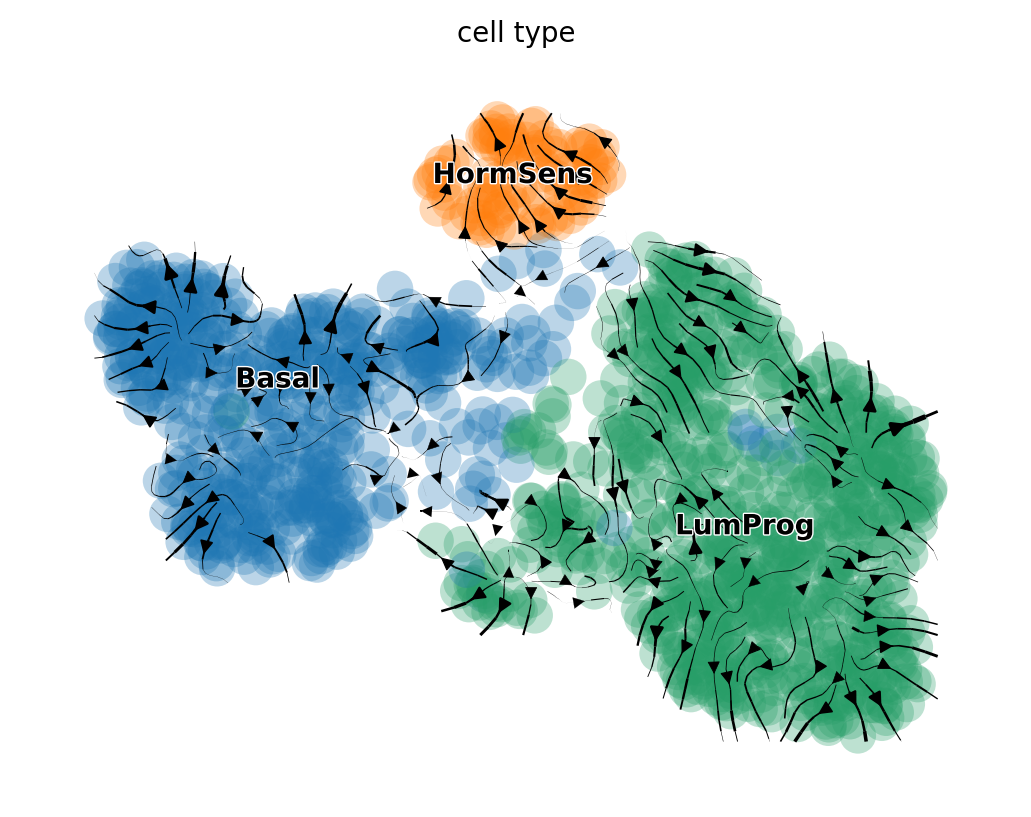

In [ ]:
ND_anndata.obs["cell_type"] = ND_anndata.obs["cell_type"].astype("category")
cats = ND_anndata.obs["cell_type"].cat.categories
palette = dict(zip(cats, sc.pl.palettes.default_20[:len(cats)]))
ND_anndata.uns["cell_type_colors"] = [palette[c] for c in cats]
umap_coords = ND_anndata.obsm['X_umap']
x_min, x_max = umap_coords[:, 0].min(), umap_coords[:, 0].max()
y_min, y_max = umap_coords[:, 1].min(), umap_coords[:, 1].max()

x_margin = (x_max - x_min) * 0.1
y_margin = (y_max - y_min) * 0.1

ax = scv.pl.velocity_embedding_stream(
    ND_anndata,
    basis="umap",
    color="cell_type",
    dpi=200,
    show=False,
    xlim=(x_min - x_margin, x_max + x_margin),
    ylim=(y_min - y_margin, y_max + y_margin)
)
ax.figure.savefig("/gpfsdata/home/renyixiang/SRTP/DeepVelo/ND_velocity_stream_celltype.png", dpi=300, bbox_inches="tight")
plt.show()

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/home/renyixiang/miniconda3/envs/deepvelo/lib/python3.9/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/gpfsdata/hom

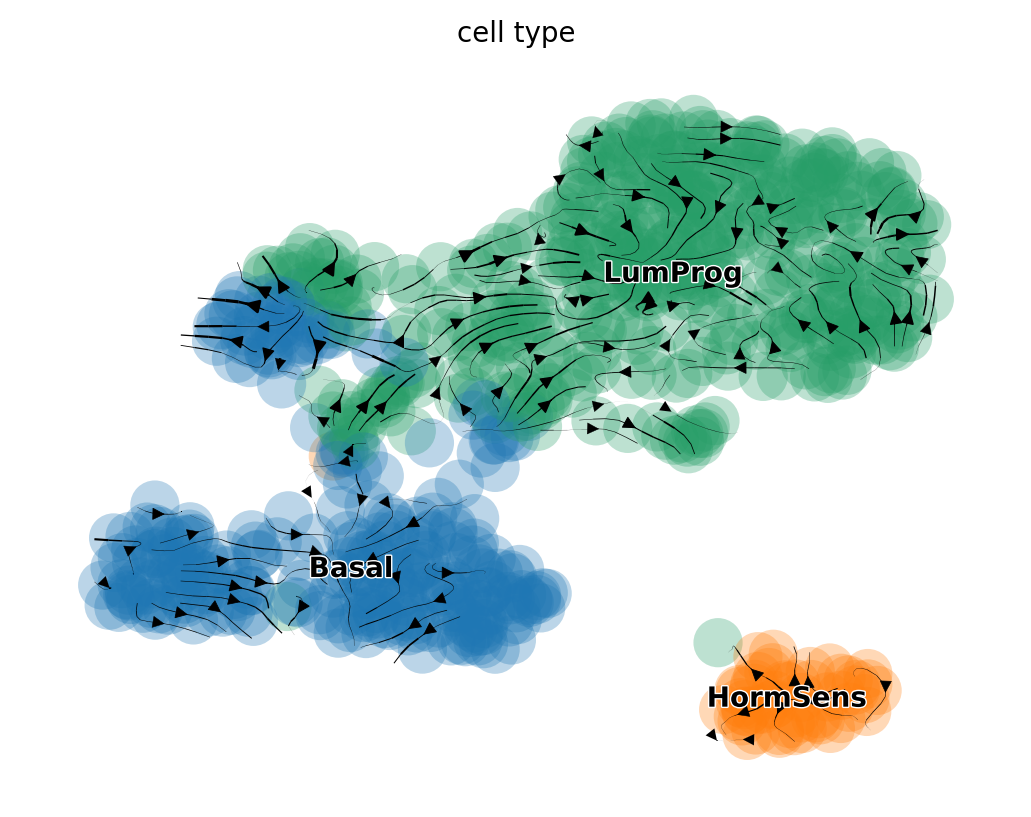

In [ ]:
HFD_anndata.obs["cell_type"] = HFD_anndata.obs["cell_type"].astype("category")
cats = HFD_anndata.obs["cell_type"].cat.categories
palette = dict(zip(cats, sc.pl.palettes.default_20[:len(cats)]))
HFD_anndata.uns["cell_type_colors"] = [palette[c] for c in cats]

umap_coords = HFD_anndata.obsm['X_umap']
x_min, x_max = umap_coords[:, 0].min(), umap_coords[:, 0].max()
y_min, y_max = umap_coords[:, 1].min(), umap_coords[:, 1].max()

x_margin = (x_max - x_min) * 0.1
y_margin = (y_max - y_min) * 0.1

ax = scv.pl.velocity_embedding_stream(
    HFD_anndata,
    basis="umap",
    color="cell_type",
    dpi=200,
    show=False,
    xlim=(x_min - x_margin, x_max + x_margin),
    ylim=(y_min - y_margin, y_max + y_margin)
)
ax.figure.savefig("/gpfsdata/home/renyixiang/SRTP/DeepVelo/HFD_velocity_stream_celltype.png", dpi=300, bbox_inches="tight")
plt.show()